In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import regexp_extract, to_timestamp, col, when, regexp_replace

# 1) SparkSession with AQE, Kryo, Arrow, etc.
spark = (
    SparkSession.builder
      .appName("EC2LogAnomalyPipeline")
      .config("spark.driver.memory", "16g")
      .config("spark.executor.memory", "16g")
      .config("spark.serializer", "org.apache.spark.serializer.KryoSerializer")
      .config("spark.sql.adaptive.enabled", "true")
      .config("spark.sql.adaptive.coalescePartitions.enabled", "true")
      .config("spark.sql.adaptive.advisoryPartitionSizeInBytes", "64MB")
      .config("spark.sql.execution.arrow.pyspark.enabled", "true")
      .config("spark.jars.packages", "com.microsoft.azure:synapseml_2.12:1.0.11")
      .config("spark.jars.repositories", "https://mmlspark.azureedge.net/maven")
      .getOrCreate()
)
spark.sparkContext.setLogLevel("WARN")
from synapse.ml.isolationforest import IsolationForest

# Parse with regex, drop rows where message is empty
raw = spark.read.text("ec2.log")
pattern = r"^(\S+)\s+([A-Z][a-z]{2}\s{1,2}\d{1,2}\s\d{2}:\d{2}:\d{2})\s+(\S+)\s+(\S+)\[(\d+)\]:\s+(.*)$"

df = (
    raw
      .select(
         regexp_extract("value", pattern, 1).alias("zulu_ts"),
         regexp_extract("value", pattern, 2).alias("syslog_ts"),
         regexp_extract("value", pattern, 3).alias("host"),
         regexp_extract("value", pattern, 4).alias("proc"),
         regexp_extract("value", pattern, 5).cast("int").alias("pid"),
         regexp_extract("value", pattern, 6).alias("message")
      )
      .filter(col("message") != "")
      .withColumn(
         "event_time",
         to_timestamp("zulu_ts", "yyyy-MM-dd'T'HH:mm:ss.SSS'Z'")
      )
      .drop("zulu_ts", "syslog_ts", "host", "pid", "event_time")
)
df = (
    df
      .withColumn("message", regexp_replace(col("message"), r'^([\d-]*) ([\d\.:]*) (\d+)', ""))
      # ← here, add the IP‐stripper:
      .withColumn(
         "message",
         regexp_replace(
           col("message"),
           r'(/|)([0-9]+\.){3}[0-9]+(:[0-9]+|)(:|)',
           ""
         )
      )
)

# 3) Label by keyword rule
anomaly_kw = r"""(?ix)               # (?i) ignore case, (?x) allow whitespace/comments
\b(?:                             # word‐boundary + non‐capturing group
    ERROR                         |  # any “ERROR”
    WARN                          |  # any “WARN”
    excessive                     |  # “excessive”
    panic                         |  # “panic”
    OutOfMemory                   |  # “OutOfMemory”
    full                          |  # “full” (e.g. filesystem full)
    timeout                       |  # “timeout”
    credential\s+rotation\s+failed|  # “credential rotation failed”
    failed\s+password\s+for\s+invalid\s+user|  # “Failed password for invalid user”
    failed\s+to\s+start           |  # “Failed to start”
    filesystem\s+full             |  # “Filesystem full”
    CPU\s+utilization\s+at\s+\d+(?:\.\d+)?%|  # “CPU utilization at 99.9%”
    IMDSv2\s+token\s+request\s+failed|        # “IMDSv2 token request failed”
    Link\s+is\s+down              |  # “Link is down”
    DHCPREQUEST\s+timeout         # “DHCPREQUEST timeout”
)\b
"""
df = df.withColumn("label", when(col("message").rlike(anomaly_kw), 1).otherwise(0))

# show the top 5 extracted rows, without truncating any fields
df.show(5, truncate=False)


25/05/15 18:03:56 WARN Utils: Your hostname, Lohits-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 10.173.168.227 instead (on interface en0)
25/05/15 18:03:56 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
https://mmlspark.azureedge.net/maven added as a remote repository with the name: repo-1
Ivy Default Cache set to: /Users/lohitgopikonda/.ivy2/cache
The jars for the packages stored in: /Users/lohitgopikonda/.ivy2/jars
com.microsoft.azure#synapseml_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-4ecfb0aa-fe00-461d-93ef-1972d337a84d;1.0
	confs: [default]
	found com.microsoft.azure#synapseml_2.12;1.0.11 in central
	found com.microsoft.azure#synapseml-core_2.12;1.0.11 in central


:: loading settings :: url = jar:file:/Users/lohitgopikonda/micromamba/lib/python3.9/site-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


	found org.apache.spark#spark-avro_2.12;3.4.1 in central
	found org.tukaani#xz;1.9 in central
	found commons-lang#commons-lang;2.6 in central
	found org.scalactic#scalactic_2.12;3.2.14 in central
	found org.scala-lang#scala-reflect;2.12.15 in central
	found io.spray#spray-json_2.12;1.3.5 in central
	found com.jcraft#jsch;0.1.54 in central
	found org.apache.httpcomponents.client5#httpclient5;5.1.3 in central
	found org.apache.httpcomponents.core5#httpcore5;5.1.3 in central
	found org.apache.httpcomponents.core5#httpcore5-h2;5.1.3 in central
	found org.slf4j#slf4j-api;1.7.25 in central
	found commons-codec#commons-codec;1.15 in central
	found org.apache.httpcomponents#httpmime;4.5.13 in central
	found org.apache.httpcomponents#httpclient;4.5.13 in central
	found org.apache.httpcomponents#httpcore;4.4.13 in central
	found commons-logging#commons-logging;1.2 in central
	found com.linkedin.isolation-forest#isolation-forest_3.4.2_2.12;3.0.4 in central
	found com.chuusai#shapeless_2.12;2.3.10

+----------------+--------------------------------------------------------------------------------------------------------+-----+
|proc            |message                                                                                                 |label|
+----------------+--------------------------------------------------------------------------------------------------------+-----+
|dhclient        |bound to  -- renewal in 1441 seconds.                                                                   |0    |
|amazon-ssm-agent|2025-04-01 00:00:03.785 INFO [CredentialRefresher] Next credential rotation will be in 29.632514 minutes|0    |
|dhclient        |DHCPACK from  (xid=0x77ce41b6)                                                                          |0    |
|auditd          |The audit daemon is exiting.                                                                            |0    |
|systemd         |Reached target Sockets.                                                 

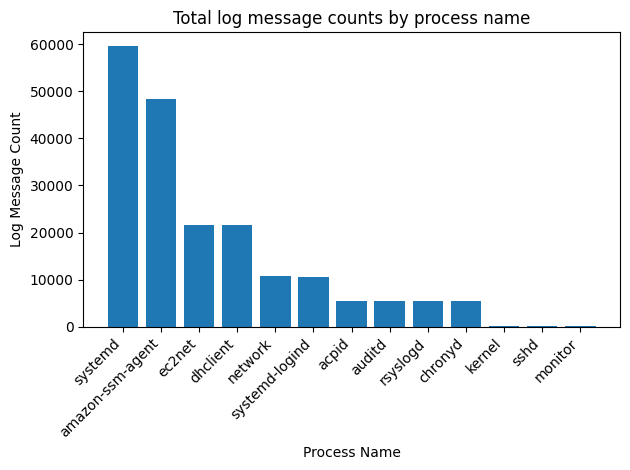

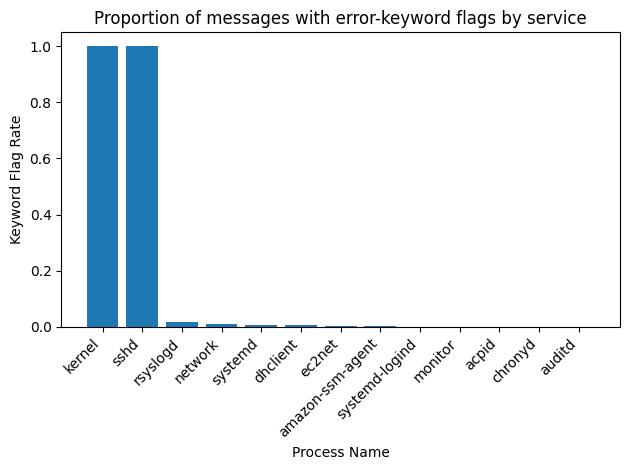

In [2]:
import matplotlib.pyplot as plt
from pyspark.sql import functions as F

# 1) Log Volume by Service
pdf_counts = (
    df
      .groupBy("proc")
      .count()
      .toPandas()
      .sort_values("count", ascending=False)
)

plt.figure()
plt.bar(pdf_counts["proc"], pdf_counts["count"])
plt.xlabel("Process Name")
plt.ylabel("Log Message Count")
plt.title("Total log message counts by process name")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


# 2) Keyword-Flag Rate per Service
pdf_rate = (
    df
      .groupBy("proc")
      .agg((F.sum("label") / F.count("*")).alias("keyword_rate"))
      .toPandas()
      .sort_values("keyword_rate", ascending=False)
)

plt.figure()
plt.bar(pdf_rate["proc"], pdf_rate["keyword_rate"])
plt.xlabel("Process Name")
plt.ylabel("Keyword Flag Rate")
plt.title("Proportion of messages with error-keyword flags by service")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


In [3]:
# setup modular pipeline and evaluation method
from pyspark.ml import Pipeline
from pyspark.ml.feature import (
    RegexTokenizer, StopWordsRemover, HashingTF, IDF, PCA, StandardScaler
)

# --- Hyperparameters ---
# HashingTF: numFeatures
num_hash_features = 4096

# PCA: k
num_pca_components = 50


pipeline = Pipeline(stages=[
    RegexTokenizer(inputCol="message",     outputCol="tokens",        pattern="\\W+"),
    StopWordsRemover(inputCol="tokens",    outputCol="filtered"),
    HashingTF(inputCol="filtered",         outputCol="rawCounts",     numFeatures=num_hash_features),
    IDF(inputCol="rawCounts",              outputCol="tfidfFeatures"),
    PCA(k=num_pca_components,              inputCol="tfidfFeatures",  outputCol="pcaFeatures"),
    StandardScaler(
       inputCol="pcaFeatures",             outputCol="scaledFeatures",
       withMean=True, withStd=True
    )
])

def evaluate_and_plot(predictions, title):
    tp = predictions.filter("prediction = 1 AND label = 1").count()
    fp = predictions.filter("prediction = 1 AND label = 0").count()
    fn = predictions.filter("prediction = 0 AND label = 1").count()
    tn = predictions.filter("prediction = 0 AND label = 0").count()

    # Handle potential division by zero if a class is not predicted at all
    if (tp + fp) == 0:
        precision = 0.0
        print("Warning: No positive predictions (tp + fp = 0). Precision is 0.")
    else:
        precision = tp / (tp + fp)

    if (tp + fn) == 0:
        recall = 0.0
        print("Warning: No actual positives in the data according to labels, or no true positives predicted (tp + fn = 0). Recall is 0.")
    else:
        recall = tp / (tp + fn)

    if (precision + recall) == 0:
        f1 = 0.0
    else:
        f1 = 2 * precision * recall / (precision + recall)

    print(f"True Positives (TP): {tp}")
    print(f"False Positives (FP): {fp}")
    print(f"False Negatives (FN): {fn}")
    print(f"True Negatives (TN): {tn}")
    print(f"Precision: {precision:.3f}, Recall: {recall:.3f}, F1: {f1:.3f}")

    # Unpersist after use
    predictions.unpersist()

    print("Preparing data for confusion matrix plot...")
    # Select only necessary columns and convert to Pandas
    pdf_results = predictions.select("label", "prediction").toPandas()
    y_true = pdf_results["label"]
    y_pred = pdf_results["prediction"]

    import matplotlib.pyplot as plt
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,5))
    cmap = plt.cm.Blues
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.ylabel('True label (Keyword)')
    plt.xlabel('Predicted label (IsolationForest)')
    plt.colorbar()
   
    unique_labels = sorted(list(set(y_true) | set(y_pred)))
    if not unique_labels: # Handle case of empty data
         unique_labels = [0,1] # Default
    tick_marks = range(len(unique_labels))
    plt.xticks(tick_marks, unique_labels)
    plt.yticks(tick_marks, unique_labels)
    threshold = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            color = "white" if cm[i, j] > threshold else "black"
            plt.text(j, i, format(cm[i, j], 'd'), # Using 'd' for integer formatting
                     ha='center', va='center',
                     color=color)
    plt.tight_layout()
    plt.show()

Starting model training...


25/05/15 18:04:42 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK
25/05/15 18:07:35 WARN DAGScheduler: Broadcasting large task binary with size 1736.6 KiB
25/05/15 18:07:38 WARN DAGScheduler: Broadcasting large task binary with size 1730.5 KiB
Java HotSpot(TM) 64-Bit Server VM warning: CodeCache is full. Compiler has been disabled.
Java HotSpot(TM) 64-Bit Server VM warning: Try increasing the code cache size using -XX:ReservedCodeCacheSize=


CodeCache: size=131072Kb used=41432Kb max_used=41432Kb free=89639Kb
 bounds [0x00000001081f8000, 0x000000010aaa8000, 0x00000001101f8000]
 total_blobs=15320 nmethods=13546 adapters=1681
 compilation: disabled (not enough contiguous free space left)


25/05/15 18:07:39 WARN DAGScheduler: Broadcasting large task binary with size 1792.2 KiB
25/05/15 18:07:39 WARN DAGScheduler: Broadcasting large task binary with size 1792.9 KiB
25/05/15 18:07:43 WARN DAGScheduler: Broadcasting large task binary with size 1826.8 KiB
25/05/15 18:07:59 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
25/05/15 18:08:26 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
25/05/15 18:08:26 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
25/05/15 18:08:27 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
25/05/15 18:08:28 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB


Model training complete. Starting transformation...
Transformation complete.


25/05/15 18:08:29 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB
25/05/15 18:08:53 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
25/05/15 18:08:53 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
25/05/15 18:08:53 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
25/05/15 18:08:53 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB


True Positives (TP): 116
False Positives (FP): 1831
False Negatives (FN): 845
True Negatives (TN): 191894
Precision: 0.060, Recall: 0.121, F1: 0.080
Preparing data for confusion matrix plot...


25/05/15 18:08:54 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB


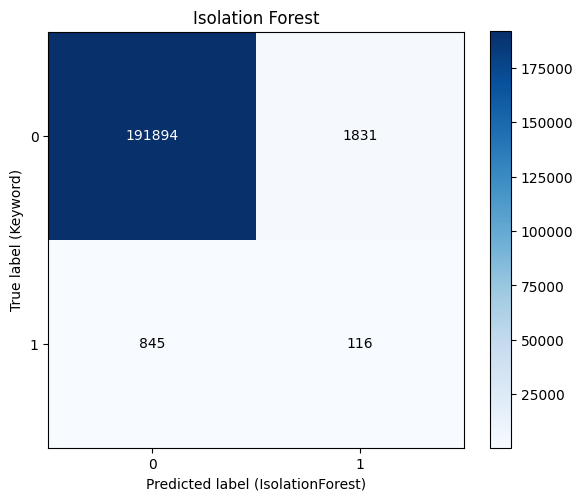

In [4]:
from synapse.ml.isolationforest import IsolationForest as SynapseIsolationForest
from pyspark.sql import functions as F # Ensure F is imported if not already

# IsolationForest:
#   - numEstimators: More trees generally lead to more stable results, but slower training.
#   - maxSamples: Proportion of samples to draw for each tree.
#     Smaller values can speed up training and help isolate anomalies better, especially if anomalies are rare.
#     The SynapseML version uses an absolute number of samples if maxSamples >= 1 or a fraction if < 1.
num_estimators = 100
max_samples_fraction = 0.2 # Changed from 0.75 to potentially speed up & improve isolation

# Updated Isolation Forest with calculated contamination
iforest = (
  SynapseIsolationForest() 
    .setNumEstimators(num_estimators)
    .setMaxSamples(max_samples_fraction)
    .setContamination(0.01) 
    .setFeaturesCol("scaledFeatures")
    .setPredictionCol("prediction")
    .setScoreCol("outlierScore")
    # .setMaxFeatures(1.0) # Proportion of features for each tree, 1.0 is default
    # .setRandomSeed(42) # For reproducibility
)

print("Starting model training...")

full_pipeline_iforest = Pipeline(stages=pipeline.getStages() + [iforest])

model = full_pipeline_iforest.fit(df)
print("Model training complete. Starting transformation...")
predictions = model.transform(df)
print("Transformation complete.")

# Persist predictions to perform evaluation actions on it
predictions.persist()

# Evaluate
evaluate_and_plot(predictions, "Isolation Forest")

Fitting Spark preprocessing pipeline for LOF...


25/05/15 18:30:06 WARN DAGScheduler: Broadcasting large task binary with size 1736.6 KiB
25/05/15 18:30:08 WARN DAGScheduler: Broadcasting large task binary with size 1730.5 KiB


Spark preprocessing model fitting complete. Starting transformation...
Spark preprocessing transformation complete.

------------------------------
------------------------------


25/05/15 18:30:09 WARN DAGScheduler: Broadcasting large task binary with size 1768.1 KiB
25/05/15 18:30:13 WARN DAGScheduler: Broadcasting large task binary with size 1770.8 KiB


Shape of X_scaled for LOF: (194686, 50)
Starting Scikit-learn LOF model fitting and prediction...
Scikit-learn LOF model fitting and prediction complete.
Creating Spark DataFrame from LOF results for evaluation...

Evaluating Local Outlier Factor Model:
True Positives (TP): 159
False Positives (FP): 1788
False Negatives (FN): 802
True Negatives (TN): 191937
Precision: 0.082, Recall: 0.165, F1: 0.109
Preparing data for confusion matrix plot...


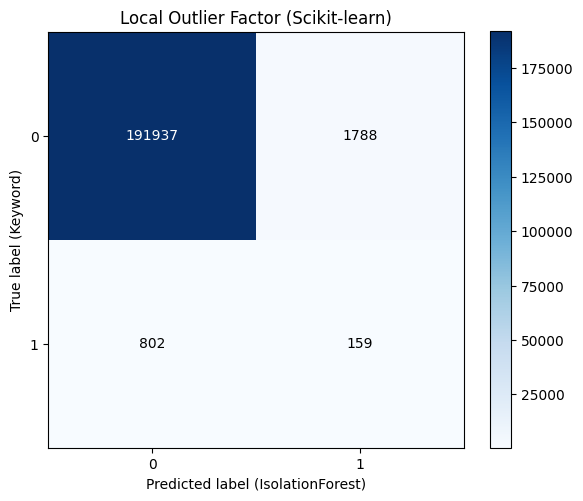


Pipeline execution finished.


In [ ]:
# scikit-learn LOF
# For fit_predict, novelty must be False (default).
# fit_predict returns -1 for outliers, 1 for inliers.

import numpy as np
import pandas as pd
from sklearn.neighbors import LocalOutlierFactor
from pyspark.sql.types import StructType, StructField, IntegerType


num_neighbors_lof = 20
contamination_lof = 0.01


sklearn_lof_model = LocalOutlierFactor(
    n_neighbors=num_neighbors_lof,
    contamination=contamination_lof,
    novelty=False 
)

# Preprocess data using the Spark ML pipeline
print("Fitting Spark preprocessing pipeline for LOF...")
spark_preprocessing_model = pipeline.fit(df) 
print("Spark preprocessing model fitting complete. Starting transformation...")
processed_df_lof = spark_preprocessing_model.transform(df)
print("Spark preprocessing transformation complete.")
processed_df_lof.persist() # Persist as it will be collected to Pandas

# --- Collect data for Scikit-learn LOF ---
print("\n" + "-" * 30)
print("Collecting features for Scikit-learn Local Outlier Factor")
print("-" * 30)

# Select scaledFeatures and label, then convert to Pandas DataFrame
features_and_labels_pd = processed_df_lof.select("scaledFeatures", "label").toPandas()
processed_df_lof.unpersist() # Unpersist after collecting to Pandas

# Extract features into a NumPy array
# Spark vector UDT needs to be converted to NumPy array for scikit-learn
X_scaled = np.array([row.toArray() for row in features_and_labels_pd["scaledFeatures"]])
y_true_lof = features_and_labels_pd["label"].values # y_true based on keyword labels

print(f"Shape of X_scaled for LOF: {X_scaled.shape}")
if X_scaled.shape[0] == 0:
    print("Error: No data to train LOF model. Exiting.")
    spark.stop()
    exit()
if X_scaled.shape[0] < num_neighbors_lof:
    print(f"Warning: n_samples ({X_scaled.shape[0]}) is less than n_neighbors ({num_neighbors_lof}). Adjusting n_neighbors.")
    sklearn_lof_model.set_params(n_neighbors=max(1, X_scaled.shape[0] -1)) # Ensure n_neighbors is less than n_samples

print("Starting Scikit-learn LOF model fitting and prediction...")
# Fit the model and predict outlier scores (-1 for outlier, 1 for inlier)
try:
    y_pred_lof_sklearn = sklearn_lof_model.fit_predict(X_scaled)
except ValueError as e:
    print(f"Error during LOF fit_predict: {e}")
    print("This can happen if n_neighbors is too large for the number of samples, or all points are identical.")
    spark.stop()
    exit()
    
print("Scikit-learn LOF model fitting and prediction complete.")

# Map LOF predictions to our convention: 1 for anomaly (outlier), 0 for normal (inlier)
# sklearn LOF: -1 is outlier, 1 is inlier
# Our convention: 1 is anomaly, 0 is normal
y_pred_mapped_lof = np.array([1 if pred == -1 else 0 for pred in y_pred_lof_sklearn])

# Create a Spark DataFrame from the scikit-learn LOF results for evaluation
print("Creating Spark DataFrame from LOF results for evaluation...")
lof_results_pd = pd.DataFrame({
    'label': y_true_lof,
    'prediction': y_pred_mapped_lof
})

# Define schema for the Spark DataFrame
schema = StructType([
    StructField("label", IntegerType(), True),
    StructField("prediction", IntegerType(), True)
])

predictions_lof_spark_df = spark.createDataFrame(lof_results_pd, schema=schema)
predictions_lof_spark_df.persist() # Persist for evaluation

# Evaluate LOF model
print("\nEvaluating Local Outlier Factor Model:")
# Pass the created Spark DataFrame to the evaluation function
evaluate_and_plot(predictions_lof_spark_df, "Local Outlier Factor (Scikit-learn)")
predictions_lof_spark_df.unpersist() # Unpersist after evaluation


print("\nPipeline execution finished.")

spark.stop() 
